# Imports

In [11]:
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    auc,
    ConfusionMatrixDisplay
)

import umap

In [12]:
df_left = pd.read_parquet("../data/l_embeddings.parquet")
df_left["embedding"] = df_left["embedding"].apply(lambda x: np.array(json.loads(x)))
df_left["label"] = "L"

df_right = pd.read_parquet("../data/r_embeddings.parquet")
df_right["embedding"] = df_right["embedding"].apply(lambda x: np.array(json.loads(x)))
df_right["label"] = "R"

df = pd.concat([df_left, df_right], ignore_index=True)
X = np.vstack(df["embedding"])
y = df["label"].values  

# Procesamiento y clasificación

In [13]:
train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])

X_train = np.vstack(train["embedding"])
y_train = train["label"].values
X_test  = np.vstack(test["embedding"])
y_test  = test["label"].values

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std  = scaler.transform(X_test)

In [14]:
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train_std, y_train)

train_acc = lr.score(X_train_std, y_train)
test_acc  = lr.score(X_test_std, y_test)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Train Accuracy: 0.9952
Test Accuracy: 0.9885


# Evaluación de resultados

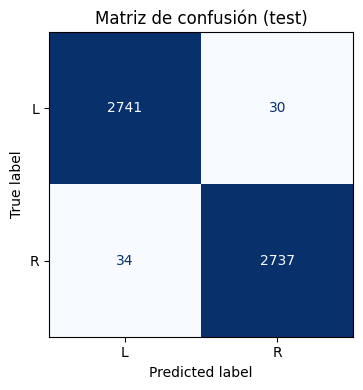

In [15]:
y_pred = lr.predict(X_test_std)

cm = confusion_matrix(y_test, y_pred, labels=["L", "R"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["L", "R"])
fig, ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax, cmap="Blues", values_format="d", colorbar=False)
ax.set_title("Matriz de confusión (test)")
plt.tight_layout()
plt.show()

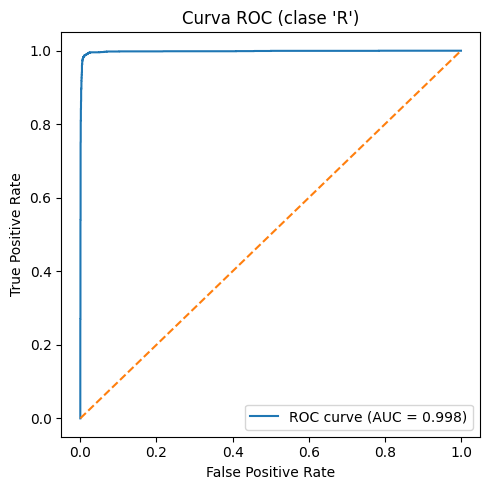

In [16]:
y_proba = lr.predict_proba(X_test_std)[:, lr.classes_.tolist().index("R")]

fpr, tpr, thresholds = roc_curve(y_test, y_proba, pos_label="R")
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC (clase 'R')")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [17]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric="cosine", random_state=42)
X_2d = reducer.fit_transform(X)

/Users/diegolarraguibel/Desktop/Semestre 2025-2/NLP/NLP-projects/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/diegolarraguibel/Desktop/Semestre 2025-2/NLP/NLP-projects/.venv/lib/python3.11/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


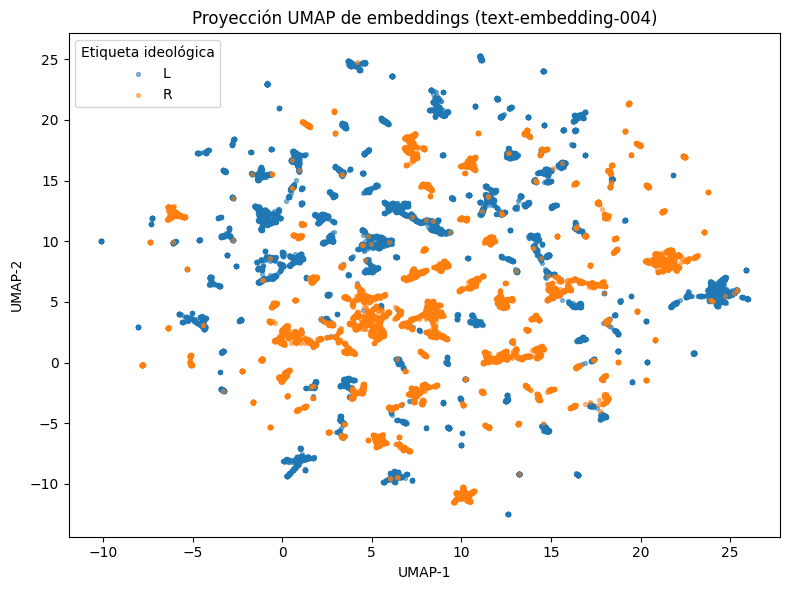

In [18]:
plt.figure(figsize=(8,6))

mask_left = (y == "L")
mask_right = (y == "R")

plt.scatter(X_2d[mask_left, 0], X_2d[mask_left, 1], s=8, alpha=0.5, label="L",)
plt.scatter(X_2d[mask_right, 0], X_2d[mask_right, 1], s=8, alpha=0.5, label="R",)

plt.legend(title="Etiqueta ideológica")
plt.title("Proyección UMAP de embeddings (text-embedding-004)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()